In [1]:
# display and plotting imports
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

import pandas as pd

#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################

from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
#flow from directory command in Keras
# this is a generator that will read pictures found in subfolers of 'Train'
train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Train",    # this is the target directory
    target_size=(224, 224),                                    # all images will be resized to 224x224
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",     #since we use categorical_crossentropy loss, we need categorical labels
    shuffle=True,
    seed=42
)

Found 2796 images belonging to 6 classes.


In [5]:
#flow from directory command in Keras
# this is a generator that will read pictures found in subfolers of 'Validation'
valid_generator = valid_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Validation",    # this is the target directory
    target_size=(224, 224),                                 # all images will be resized to 224x224
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",  #since we use categorical_crossentropy loss, we need categorical labels
    shuffle=True,
    seed=42
)

Found 2763 images belonging to 6 classes.


In [6]:
#flow from directory command in Keras
# this is a generator that will read pictures found in subfolers of 'Test'
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Test",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 3658 images belonging to 1 classes.


In [7]:
#Fitting/Training the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
87/87 [==============================] - 1066s 12s/step - loss: 1.4470 - accuracy: 0.6863 - val_loss: 0.5256 - val_accuracy: 0.8136
Epoch 2/15
87/87 [==============================] - 82s 938ms/step - loss: 0.2828 - accuracy: 0.9096 - val_loss: 0.3575 - val_accuracy: 0.8852
Epoch 3/15
87/87 [==============================] - 81s 937ms/step - loss: 0.1758 - accuracy: 0.9475 - val_loss: 0.3444 - val_accuracy: 0.8917
Epoch 4/15
87/87 [==============================] - 82s 940ms/step - loss: 0.1742 - accuracy: 0.9468 - val_loss: 0.3127 - val_accuracy: 0.9015
Epoch 5/15
87/87 [==============================] - 82s 944ms/step - loss: 0.1619 - accuracy: 0.9446 - val_loss: 0.4429 - val_accuracy: 0.8790
Epoch 6/15
87/87 [==============================] - 82s 943ms/step - loss: 0.1712 - accuracy: 0.9432 - val_loss: 0.4097 - val_accuracy: 0.8863
Epoch 7/15
87/87 [==============================] - 82s 938ms/step

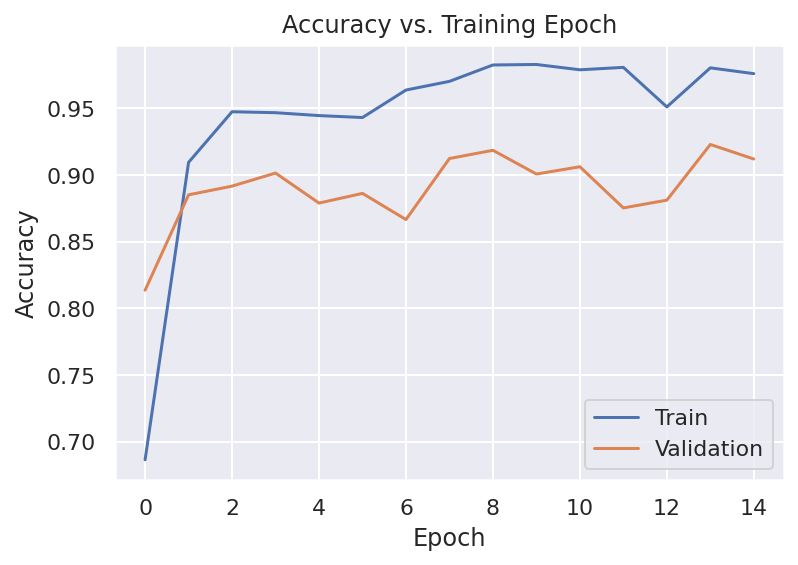

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation']);

In [35]:
#Targeted Categories (numerical labels)
true_classes = valid_generator.classes
#Targeted Categories (labels)
class_labels = list(valid_generator.class_indices.keys())  

In [82]:
#Sklearn confusion matrix
#Model Accuracy metrics
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(valid_generator.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
class_labels = list(valid_generator.class_indices.keys())  
print(classification_report(valid_generator.classes, y_pred, target_names = class_labels))

Confusion Matrix
[[135 169  30 108 133  41]
 [150 219  40 117 171  52]
 [ 38  41  12  24  25  11]
 [ 69 126  25  65  91  30]
 [132 164  41 124 121  27]
 [ 68  55  10  34  56   9]]
Classification Report
                precision    recall  f1-score   support

        Adidas       0.23      0.22      0.22       616
    Air Jordan       0.28      0.29      0.29       749
          Kobe       0.08      0.08      0.08       151
Nike Air Force       0.14      0.16      0.15       406
  Nike Air Max       0.20      0.20      0.20       609
       Nike SB       0.05      0.04      0.04       232

      accuracy                           0.20      2763
     macro avg       0.16      0.16      0.16      2763
  weighted avg       0.20      0.20      0.20      2763



In [75]:
#cnn_pred_cifar = model.predict(x_test)
Y_pred = model.predict_generator(valid_generator)

#cnn_pred_cifar = np.argmax(cnn_pred_cifar,axis=1)
y_pred = np.argmax(Y_pred, axis=1)


#y_true = np.argmax(y_test_tf,axis=1)
y_true = np.argmax(valid_generator.classes ,axis=0)





-----------------Convolutional Neural Network Report---------------


TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [76]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix2(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[142 159  25 114 141  35]
 [168 210  38 128 156  49]
 [ 24  53   9  24  27  14]
 [ 82 128  24  58  89  25]
 [129 166  43 105 139  27]
 [ 47  58  19  43  45  20]]


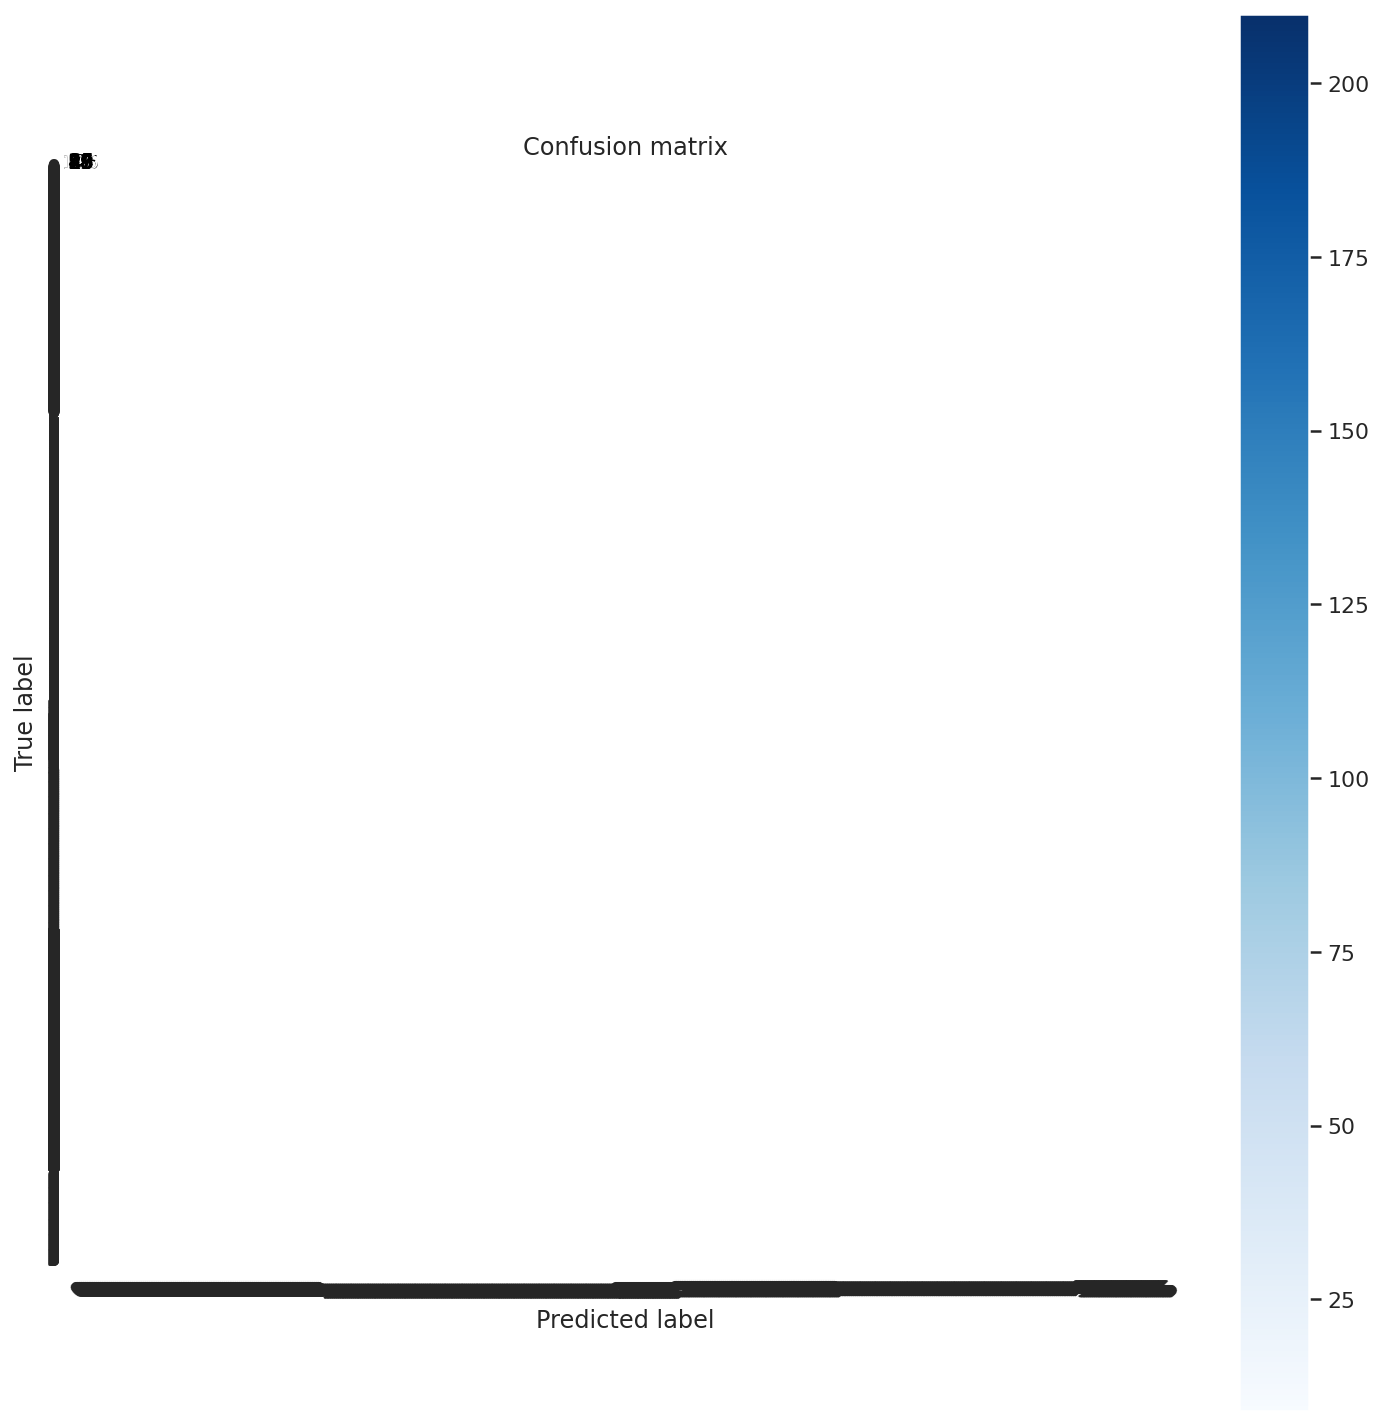

In [77]:
#Confusion Matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix2(cm, valid_generator.classes)

In [13]:
from keras.models import Model
import keras
inter_model = keras.Model(model.input, model.layers[-2].output)
inter_output = inter_model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [14]:
shoe_name = test_generator.filenames

In [87]:
#Get vector from CNN and pass through pair wise distance
from sklearn.metrics import pairwise_distances
d = pairwise_distances(inter_output,metric='cosine')

[shoe_name[m] for m in d[1].argsort()[:20]] #for Sneaker #1

["Test/1 retro high bg 'Rare Air'.png",
 "Test/Air Jordan 1 Retro High 'Rare Air'.png",
 "Test/Air Jordan 1 Mid 'Grey Volt'.png",
 "Test/Air Jordan 1 Mid Noveau 'BHM'.png",
 "Test/Air Jordan 1 Mid 'Glow In The Dark'.png",
 "Test/Wmns Air Jordan 1 High OG 'UNC To Chicago'.png",
 "Test/Air Jordan 1 Mid 'Maybe I Destroyed the Game'.png",
 "Test/Air Jordan 1 Retro High 'Melo'.png",
 "Test/Air Jordan 1 Mid 'Michigan'.png",
 "Test/Air Jordan 1 Retro High Premium 'Grey Camo'.png",
 "Test/Air Jordan 1 Mid Retro SE 'Grey Fog'.png",
 "Test/Air Jordan 1 Retro High OG BG 'Shattered Backboard 3.0'.png",
 "Test/Air Jordan 1 Mid 'Game Royal'.png",
 "Test/Air Jordan 1 Retro Phat Premier 'Midnight Navy'.png",
 "Test/Air Jordan 1 Retro High OG BG 'Perforated'.png",
 "Test/AJKO High OG 'Bred'.png",
 "Test/Wmns Air Jordan 1 Mid SE 'Black Barely Volt'.png",
 "Test/Air Jordan 1 Retro Mid 'White Concord'.png",
 "Test/Air Jordan 1 Mid 'UNC'.png",
 "Test/Air Jordan 1 Mid Patent TD 'Black Gold'.png"]

In [79]:
proba = model.predict(valid_generator)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-7:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(6):
    print("{}".format(class_labels[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

Kobe (0.636)
Air Jordan (0.321)
Nike Air Max (0.0331)
Adidas (0.0089)
Nike Air Force (0.00135)
Nike SB (4.15e-05)
